# Описание проекта

Данные о клиентах банка предоставлены менеджерами банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Задача: Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.**

## Изучение данных из файла  

In [31]:
import pandas as pd # импорт библиотек
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
!pip install plotly

In [32]:
from io import BytesIO

import requests
spreadsheet_id = '2PACX-1vT9iOI2fUEnp2ujnZkGIMPAbyVmb0FqGZ4gm87yW43U0M6VemaFpwI3lmhoBSY_2QgMqF8o9VFpLS7K'
file_name = 'https://docs.google.com/spreadsheets/d/e/{}/pub?output=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content)) # чтение файла
df.head(10) # вывод первых 10 строк таблицы

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [33]:
df.info() # вывод данных о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Вывод

Преведены данные клиентов банка. Можно выделить из них одну целевую переменную (`Churn`) и  10 признаков. Предварительно можно утверждать, что данных достаточно. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

## Предобработка данных

### Исследование пропущенных значений

In [34]:
df.isna().sum() # вывод количества пропусков по столбцам

userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

Пропуски в столбце `Balance` составляют 36,17 % от общего количества данных в признаке `Balance`.

In [35]:
df1 = df[['City','Balance']]
df1['Balance'] = df1['Balance'].fillna('unknown') # замена пропущенных значений на 'unknown'
df1 = df1[df1['Balance'] == 'unknown'] 
df1.groupby('City')['Balance'].value_counts() # подсчет количества пропущенных значений 
                                              # в столбце `Balance` с разбивкой по городам

/tmp/ipykernel_31/1425649958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Balance'] = df1['Balance'].fillna('unknown') # замена пропущенных значений на 'unknown'


City       Balance
Рыбинск    unknown    1199
Ярославль  unknown    2418
Name: Balance, dtype: int64

In [36]:
df.groupby('City')['userid'].count() # подсчет количества клиентов с разбивкой по городам

City
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: userid, dtype: int64

Думаю, что NaN в значении баланса значит, что на балансе нет средств, и поэтому думаю, что данные пропуски не стоит заполнять медианными или средними значениями, так как это сильно повлияет на распределение данного признака для городов Рыбинск и Ярославль (для Рыбинска 48% пропущенных значений, для Ярославля также 48% пропущенных значений в столбце `Balance`).

### Исследовать соответствие типов

Типы соответствуют приведенным в столбцах данным. Изменение типов не требуется.

### Исследовать дубликаты

In [37]:
df.duplicated().sum() # подсчёт явных дубликатов

0

Явные дубликаты отсутствуют. Теперь проверим наличие неявных дубликаты.

In [38]:
df['City'].unique() # дубликаты среди названий городов отсутствуют

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [39]:
df['Gender'].unique() # дубликаты среди названий пола отсутствуют

array(['Ж', 'М'], dtype=object)

### Проверить корректность наименований колонок

Приведем названия колонок к нижнему регистру.

In [40]:
df.columns = df.columns.str.lower() # приведем к нижнему регистру названия столбцов

In [41]:
df = df.rename(columns = {'userid': 'user_id', 'creditcard':'credit_card'}) # перезапись названия столбцов змеиным регистром


### Вывод

1. Привела названия столбцов к нижнему регистру, и перезаписала змеиным регистром.

2. Пропуски решено не заполнять, так как они существенно могут повлиять на выводы для городов Рыбинск и Ярославль.

3. Дубликатов не обнаружено.

## Исследовательский анализ данных

In [42]:
df.query('churn ==1')['churn'].count() # количество клиентов в оттоке 


2037

In [43]:
'Процент оттока на 10000 человек составляет', 2037/10000*100, '%'

('Процент оттока на 10000 человек составляет', 20.369999999999997, '%')

### Изучение признаков клиентов, изучение средних значений и стандартных отклонений признаков

In [44]:
df.describe() # вывод средних значений и стандартных отклонений

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


На первый взгляд видимых выбросов нет, нет нелогичных значений, кроме заработной платы 	`estimated_salary`,  где в минимальных значениях стоит 11,58, что не может соответствовать действительности.

In [45]:
df.groupby('churn').mean() # средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


Средние значения признаков групп практически все схожи, кроме двух признаков - это `age` и `loyalty`. В группе клиентов, ушедших в отток, возраст больше, и меньше активность.

In [46]:
df_credit_card = df.groupby(['churn']).agg({'user_id':'nunique'})
df_credit_card['credit_card1'] = df.query('credit_card == 1').groupby(['churn']).agg({'credit_card':'count'}).sort_values(by='credit_card', ascending=False)
df_credit_card['credit_card1_part'] = df_credit_card['credit_card1'] / df_credit_card['user_id'] * 100
df_credit_card.sort_values(by='credit_card1_part', ascending=False) # вывод количества клиентов, количества клиентов, пользующихся кредитной картой в двух группах

# пользование кредитной картой у двух групп практически одинаковое.

,user_id,credit_card1,credit_card1_part
churn,,,
0,7963,5631,70.714555
1,2037,1424,69.906726


Пользование кредитной картой у двух групп практически одинаковое.

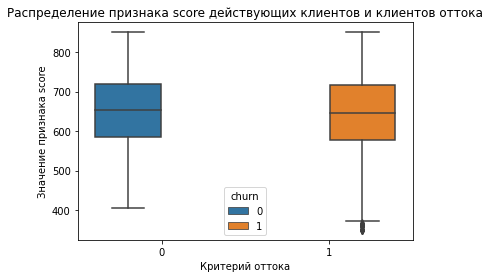

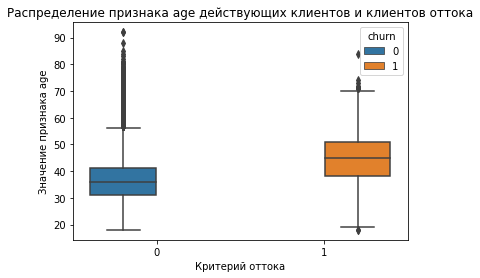

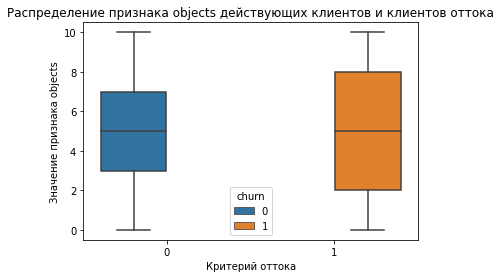

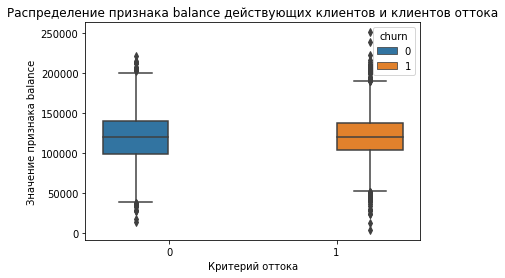

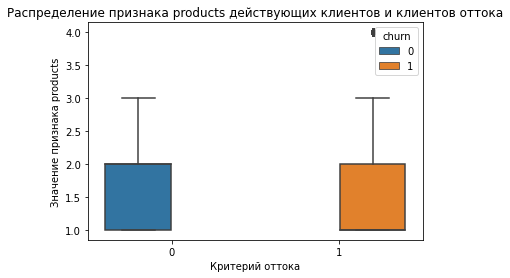

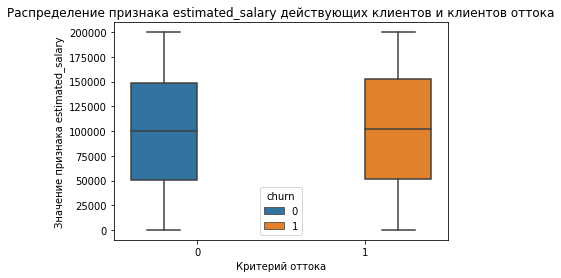

In [47]:
columns = ['score','age', 'objects', 'balance', 'products', 'estimated_salary'] # построение "ящика с усами" для признаков оттока 

for column in columns:
    sns.boxplot(x='churn', y=column, hue='churn', data=df)
    plt.title(f'Распределение признака {column} действующих клиентов и клиентов оттока')
    plt.xlabel("Критерий оттока")
    plt.ylabel(f'Значение признака {column}')
    plt.show()


Выбросы присутствуют в признаках `score`,  `age`, `balance`.

### Построение столбчатых гистограмм признаков целевых групп (кто ушёл в отток и тех, кто остался)

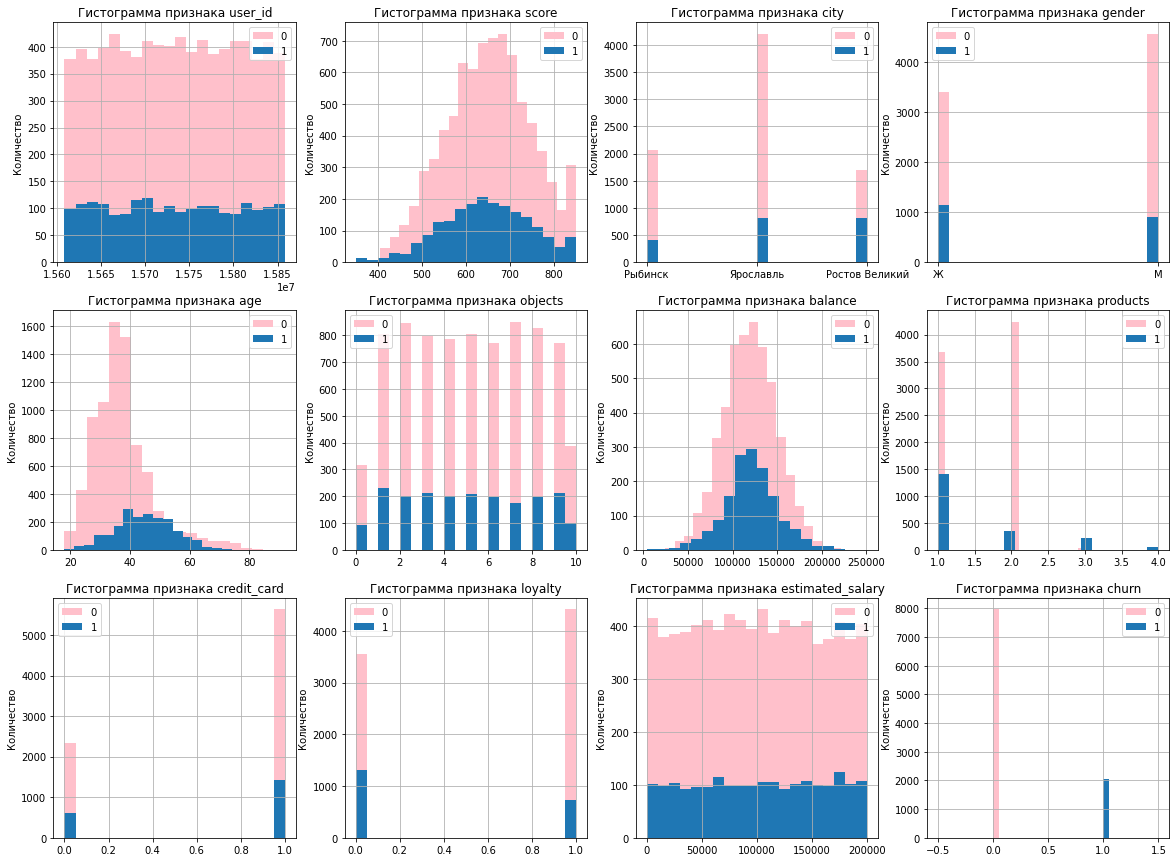

In [48]:
plt.figure(figsize=(20, 15)) # построение столбчатых гистограмм признаков для групп оттока и активных клиентов

for i, col in enumerate(df.columns):
   
    plt.subplot(3, 4, i+1)
    ax = df.query('churn==0')[col].hist(label=0, bins=20, color='pink')
    ax = df.query('churn==1')[col].hist(label=1, bins=20)
    plt.title(f'Гистограмма признака {col}')
    plt.ylabel('Количество')
    plt.legend()
    

Признаки `score`, `age`, `balance` распределены нормально.

По гендерному признаку `gender`, количеству объектов `objects`, заработной плате `estimated_salary` распределение равномерно.

По количеству используемых продуктов `products` - в группе оттока, у клиентов было открыто 1, 2, 3, и 4 продукта (в основном  один продукт), в группе действующих клиентов- 1, 2, 3 открытых продукта (в основном один или два продукта).

По количеству использования кредитных карт `credit_card`- у группы оттока и группы действующих клиентов наличие в  пользовании кредитной карты одинаковое.

По статусу активного клиента `loyalty`- в группе оттока менее активные клиенты.



### Построение матрицы корреляций (выделить признаки, которые наиболее коррелируются с целевой переменой)

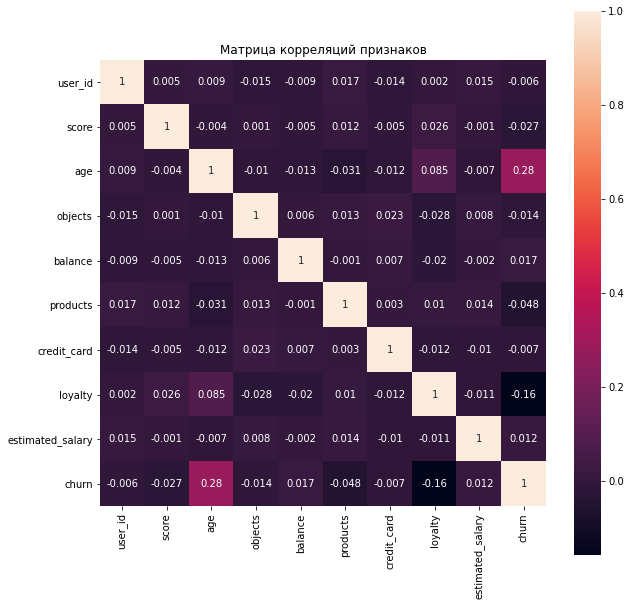

In [49]:
cm = df.corr() # вычисляем матрицу корреляций

fig, ax = plt.subplots(figsize =(10, 10))
sns.heatmap(cm.round(3), annot=True, square=True) # нарисуем тепловую карту с подписями для матрицы корреляций
plt.title('Матрица корреляций признаков')
plt.show()

Наиболее коррелируют с целевой переменной два признака - это `age` (возраст) и `loyalty` (активность).

Построим матрицу корреляций с учетом категориальной переменной `city`.

In [50]:
s = pd.Series(df['city'])
s_1 = pd.get_dummies(s) # one-hot кодировка категориальной переменной `city`

In [51]:
df_3 = pd.concat([df, s_1], sort=False,axis=1)
df_3

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,0,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,0,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0,0,0,1
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1,0,0,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1,1,0,0


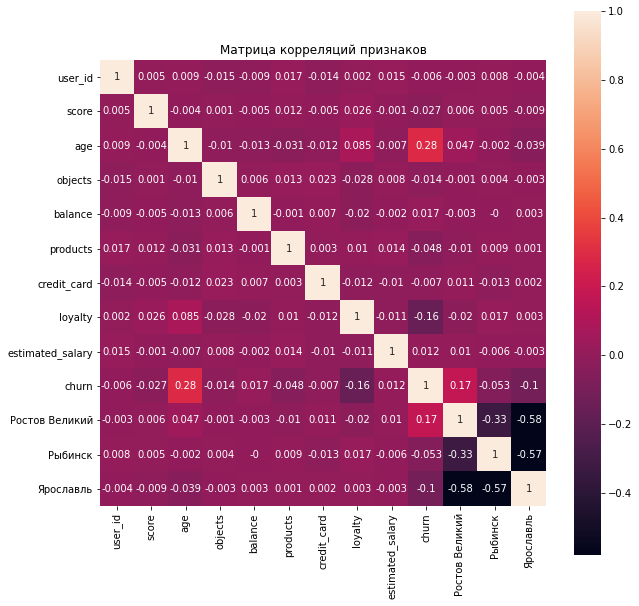

In [52]:
cm_1 = df_3.corr() # вычисляем матрицу корреляций с учетом категориальными переменными `city`

fig, ax = plt.subplots(figsize =(10, 10))
sns.heatmap(cm_1.round(3), annot=True, square=True) # нарисуем тепловую карту с подписями для матрицы корреляций
plt.title('Матрица корреляций признаков')
plt.show()

Наиболее коррелирует с целевой переменной категориальная переменная со значением- Ростов Великий.

### Определение процента оттока из банка для разных городов (из какого города отток больше? характерен ли отток для какого-то определенного города?)

In [53]:
df_city = df.groupby(['city']).agg({'user_id':'nunique'})
df_city['churn1'] = df.query('churn == 1').groupby(['city']).agg({'churn':'count'}).sort_values(by='churn', ascending=False)
df_city['churn1_part'] = df_city['churn1'] / df_city['user_id'] * 100
df_city.sort_values(by='churn1_part', ascending=False) # вывод количества клиентов, количества клиентов, ушедших в оттток с разбивкой по городам

,user_id,churn1,churn1_part
city,,,
Ростов Великий,2509,814,32.443204
Рыбинск,2477,413,16.673395
Ярославль,5014,810,16.154767


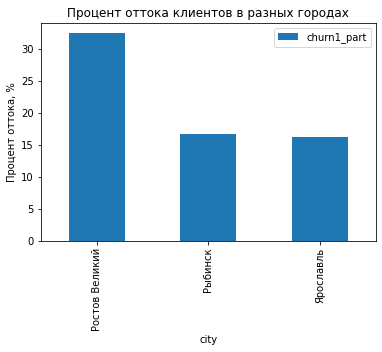

In [54]:
df_city.plot(y = 'churn1_part',  kind='bar')
plt.title(f'Процент оттока клиентов в разных городах')
plt.ylabel('Процент оттока, %')
plt.legend()
plt.show()

Отток клиентов характерен для клиентов из города Ростов Великий, отток клиентов составляет 32%. Для городов Рыбинск и Ярославль отток в процентном отношении одинаков и составляет около 16%. 

### Определение средних значений признаков с разбивкой по городам (одинаковы ли средние значения признаков для разных городов?)

In [55]:
df.groupby(['city', 'churn']).mean() # вывод средних значений признаков оттока клиентов с разбивкой по городам

user_id       score        age   objects  \
city           churn                                                  
Ростов Великий 0      1.573418e+07  653.261357  37.311504  5.011799   
               1      1.573144e+07  647.689189  44.894349  5.006143   
Рыбинск        0      1.573550e+07  652.104167  37.839147  5.107558   
               1      1.573042e+07  647.484262  44.147700  4.656174   
Ярославль      0      1.573301e+07  651.162226  37.235966  5.005471   
               1      1.573535e+07  641.914815  45.133333  5.000000   

                            balance  products  credit_card   loyalty  \
city           churn                                                   
Ростов Великий 0      119427.106696  1.551032     0.716224  0.561652   
               1      120361.075590  1.454545     0.708845  0.363636   
Рыбинск        0      119820.561722  1.544574     0.699128  0.567345   
               1      119792.058240  1.513317     0.673123  0.341404   
Ярославль      0      119484.839826  1.541389     0.707422  0.545433   
               1      121915.781268  1.476543     0.702469  0.367901   

                      estimated_salary  
city           churn                    
Ростов Великий 0         102414.657876  
               1          98403.886450  
Рыбинск        0          98602.369864  
               1         103629.554818  
Ярославль      0          99217.097331  
               1         103439.278296

Для клиентов, ушедших в отток, можно выделить два отличающих признака - это более старший возраст и меньшая активность, по сравнению с группами действующих клиентов. Значения всех остальных признаков примерно одинаковы для разных групп.

### Определение процента оттока клиентов  и их активности с разбивкой по возрастным категориям

In [56]:
def age_id(row): #функция для категоризации данных по возрасту
    if 18 <= row <=25:
        return "18-25"
    if 26 <= row <=30:
        return "26-30"
    if 31 <= row <=35:
        return "31-35"
    if 36 <= row <=40:
        return "36-40"
    if 41 <= row <=45:
        return "41-45"
    if 46 <= row <=50:
        return "46-50"
    if 41 <= row <=45:
        return "41-45"
    if 46 <= row <=50:
        return "46-50"
    if 51 <= row <=60:
        return "51-60"
    if row > 60:
        return "более 60"
    
    
df['category_age']= df['age'].apply(age_id)

In [57]:
df.head(10) # данные с разбивкой клиентов по возрастным категориям

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,category_age
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,41-45
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,41-45
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,41-45
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,36-40
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,41-45
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1,41-45
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0,46-50
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1,26-30
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0,41-45
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0,26-30


In [58]:
df_age = df.groupby(['category_age']).agg({'user_id':'nunique'}) # группировка по возрастным категориям
df_age['churn1'] = df.query('churn==1').groupby(['category_age'])['user_id'].count() # количество клиентов в оттоке в возрастной категории
df_age['churn1_part'] = df_age['churn1'] / df_age['user_id'] * 100 # процент оттока в возрастной категории
df_age # вывод процента оттока по разным возрастным категориям

,user_id,churn1,churn1_part
category_age,,,
18-25,611,46,7.528642
26-30,1357,102,7.516581
31-35,2185,199,9.107551
36-40,2266,339,14.960282
41-45,1470,394,26.802721
46-50,850,394,46.352941
51-60,797,448,56.210790
более 60,464,115,24.784483


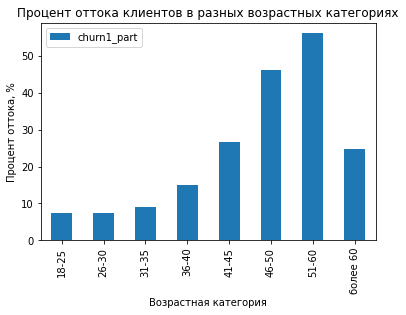

In [66]:
df_age.plot(y = 'churn1_part',  kind='bar')
plt.title(f'Процент оттока клиентов в разных возрастных категориях')
plt.ylabel('Процент оттока, %')
plt.xlabel('Возрастная категория')
plt.legend()
plt.show()

По данной таблице видим, что 27 % оттока клиентов начинается с возрастной группы 41-45, постепенно увеличиваясь до возрастной группы 51-60.

In [59]:
df_loyalty = df.groupby(['category_age']).agg({'user_id':'nunique'})  # группировка по возрастным категориям
df_loyalty['loyalty1'] = df.query('loyalty==1').groupby(['category_age'])['user_id'].count() # количество активных клиентов в возрастной категории
df_loyalty['loyalty1_part'] = df_loyalty['loyalty1'] / df_loyalty['user_id'] * 100 # процент активных клиентов в возрастной категории
df_loyalty # вывод процента активности по разным возрастным категориям

,user_id,loyalty1,loyalty1_part
category_age,,,
18-25,611,323,52.864157
26-30,1357,683,50.331614
31-35,2185,1119,51.212815
36-40,2266,1096,48.367167
41-45,1470,695,47.278912
46-50,850,399,46.941176
51-60,797,461,57.841907
более 60,464,375,80.818966


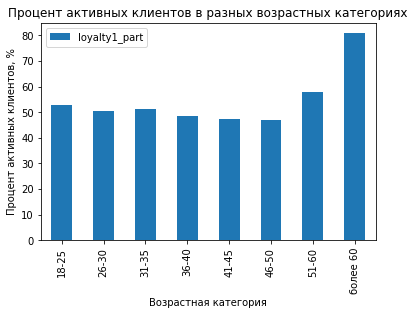

In [84]:
df_loyalty.plot(y = 'loyalty1_part',  kind='bar')
plt.title(f'Процент активных клиентов в разных возрастных категориях')
plt.ylabel('Процент активных клиентов, %')
plt.xlabel('Возрастная категория')
plt.legend()
plt.show()

Подтверждается меньшая активность клиентов в возрастных группах 36-40, 41-45, 46-50.

In [60]:
df_4 = df.groupby(['category_age', 'city']).mean() # средние значения признаков с разбивкой на возрастные категории и города

user_id       score        age   objects  \
category_age city                                                            
18-25        Ростов Великий  1.572936e+07  639.454545  23.055944  5.076923   
             Рыбинск         1.573919e+07  650.580247  22.765432  5.833333   
             Ярославль       1.573075e+07  656.941176  22.810458  4.898693   
26-30        Ростов Великий  1.573300e+07  657.200000  28.338710  4.835484   
             Рыбинск         1.573192e+07  645.812698  28.285714  5.028571   
             Ярославль       1.572994e+07  651.010929  28.270492  5.107923   
31-35        Ростов Великий  1.573288e+07  656.927126  33.087045  4.914980   
             Рыбинск         1.573422e+07  648.281481  33.140741  5.214815   
             Ярославль       1.573410e+07  647.923545  33.043440  4.982624   
36-40        Ростов Великий  1.573788e+07  656.183712  37.984848  5.179924   
             Рыбинск         1.573420e+07  656.527682  37.904844  4.865052   
             Ярославль       1.573341e+07  649.181034  37.965517  4.987931   
41-45        Ростов Великий  1.573247e+07  648.398568  42.821002  4.997613   
             Рыбинск         1.573067e+07  652.540984  42.754098  4.942623   
             Ярославль       1.573415e+07  650.118248  42.747445  4.973723   
46-50        Ростов Великий  1.573335e+07  645.528958  47.888031  5.092664   
             Рыбинск         1.573314e+07  646.287081  47.622010  5.076555   
             Ярославль       1.573825e+07  646.850785  47.727749  4.908377   
51-60        Ростов Великий  1.573121e+07  644.563786  54.839506  4.925926   
             Рыбинск         1.574345e+07  655.010695  54.978610  4.561497   
             Ярославль       1.573377e+07  644.013624  55.021798  5.267030   
более 60     Ростов Великий  1.572684e+07  644.566372  67.548673  5.061947   
             Рыбинск         1.574093e+07  654.941667  67.066667  4.875000   
             Ярославль       1.573324e+07  659.229437  67.722944  4.844156   

                                   balance  products  credit_card   loyalty  \
category_age city                                                             
18-25        Ростов Великий  119192.591189  1.489510     0.720280  0.496503   
             Рыбинск         124242.111375  1.555556     0.703704  0.543210   
             Ярославль       123526.973660  1.575163     0.683007  0.535948   
26-30        Ростов Великий  119184.353710  1.509677     0.741935  0.516129   
             Рыбинск         119909.196974  1.625397     0.701587  0.504762   
             Ярославль       119439.676778  1.549180     0.714481  0.497268   
31-35        Ростов Великий  120248.778583  1.528340     0.724696  0.530364   
             Рыбинск         117505.500295  1.531481     0.700000  0.522222   
             Ярославль       120299.640411  1.526499     0.723719  0.499566   
36-40        Ростов Великий  118794.099470  1.573864     0.710227  0.479167   
             Рыбинск         121957.889430  1.543253     0.714533  0.496540   
             Ярославль       120604.532215  1.523276     0.700000  0.479310   
41-45        Ростов Великий  119377.787757  1.568019     0.687351  0.463007   
             Рыбинск         117552.730677  1.538251     0.653005  0.453552   
             Ярославль       120502.579006  1.543066     0.700730  0.489051   
46-50        Ростов Великий  120496.115830  1.428571     0.745174  0.440154   
             Рыбинск         118254.685000  1.483254     0.688995  0.507177   
             Ярославль       120566.970408  1.539267     0.701571  0.468586   
51-60        Ростов Великий  121549.125967  1.452675     0.674897  0.460905   
             Рыбинск         120794.616476  1.508021     0.647059  0.663102   
             Ярославль       116110.164356  1.449591     0.711172  0.613079   
более 60     Ростов Великий  119652.790885  1.469027     0.707965  0.725664   
             Рыбинск         121866.266406  1.458333     0.758333  0.833333   
             Ярославль       1

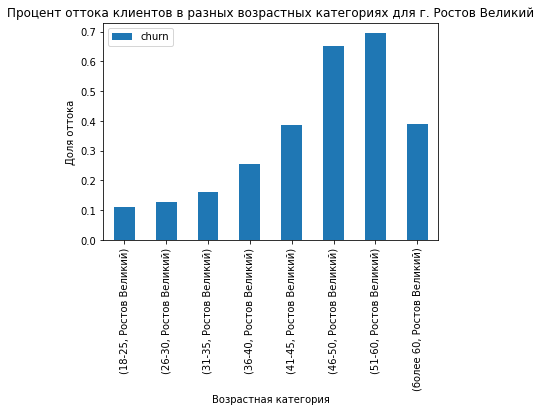

In [83]:
df_4.query('city == "Ростов Великий"').plot(y='churn', kind='bar')
plt.title(f'Процент оттока клиентов в разных возрастных категориях для г. Ростов Великий')
plt.ylabel('Доля оттока')
plt.xlabel('Возрастная категория')
plt.legend()
plt.show()

Для города Ростова Великий отток клиентов в 26% начинается для возрастной категории 36-40 лет.

### Вывод

1. Наиболее весомыми признаками оттока можно назвать `age` (возраст) и `loyalty` (активность).  
2. Для группы оттока характерны более низкая активность и более старший возраст (более 45 лет).
3. Для группы действующих клиентов характерны более высокая активность пользования продуктами и  более молодой возраст (около 37 лет в среднем).
4. В городе Ростов Великий существенно больший отток клиентов - 32%, по сравнению с другими городами (около 16%). Отток клиентов для этого города начинается с возрастной категории 36-40 лет и так же клиенты входят в категорию неактивных.

## Формулирование и проверка статистических гипотез

Для проверки гипотез будем использовать статистический тест: Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

Сформулируем нулевую гипотезу: доходы действующих клиентов и клиентов ушедших в отток равны.

In [61]:
df_churn1 = df.query('churn == 1') # срез данных действующих клиентов
df_churn0 = df.query('churn == 0') # срез данных клиентов в оттоке
df_churn1['estimated_salary'] # выборка с доходами действующих клиентов
df_churn0['estimated_salary'] # выборка с доходами клиентов в оттоке

1       112542.58
3        93826.63
4        79084.10
6        10062.80
8        74940.50
          ...    
9993     29179.52
9994    167773.55
9995     96270.64
9996    101699.77
9999     38190.78
Name: estimated_salary, Length: 7963, dtype: float64

In [62]:
from scipy import stats as st

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(df_churn1['estimated_salary'], df_churn0['estimated_salary'], equal_var = False) 
# параметр equal_var = False так как выборки разного размера

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print(results.pvalue)   

Не получилось отвергнуть нулевую гипотезу
0.228924613051458


### Проверка гипотезы различия количества продуктов в пользовании между теми клиентами, которые ушли и теми, которые остались.

Сформулируем нулевую гипотезу: количество продуктов в пользовании действующих клиентов и клиентов ушедших в отток равны.

In [63]:
df_churn1['products'] # выборка с количеством используемых продуктов действующих клиентов
df_churn0['products'] # выборка с количеством используемых продуктов клиентов в оттоке

1       1
3       2
4       1
6       2
8       2
       ..
9993    1
9994    2
9995    2
9996    1
9999    1
Name: products, Length: 7963, dtype: int64

In [64]:
from scipy import stats as st

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(df_churn1['products'], df_churn0['products'], equal_var = False)
# параметр equal_var = False так как выборки разного размера

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print(results.pvalue) 

Отвергаем нулевую гипотезу
0.00021858494460549394


### Вывод

1. Не получилось отвергнуть нулевую гипотезу - статистическая вероятность равенства дохода клиентов группы, которые ушли в отток и группы действующих клиентов равна 22%.
2. Отвергаем нулевую гипотезу - статистическая вероятность того, что количество используемых продуктов группы, которые ушли в отток и группы действующих клиентов равны, очень мала и составляет 0.00022%.

## Вывод


1.Общий процент оттока на 10000 клиентов составляет 20 %.

2.На отток в большей степени влияют два показателя это более старший возраст и меньшая активность клиента. Остальные показатели значительной роли не играют и их параметры схожи в двух группах.

3.Чаще всего в отток уходят клиенты в возрастных групп 41-45 лет  (27% оттока), 46-50 лет (46 % оттока), 51-60 лет (56 % оттока).

4.Менее активны клиенты в возрастных группах 36-40, 41-45, 46-50 лет.

5.Больше всего отток клиентов характерен для города Ростов Великий (32% оттока). Для данного города отток клиентов уже начинается с возрастной группы 36-40 лет. Клиенты группы оттока также относятся к категории менее активных пользователей.


*Рекомендации по удержанию оттока:*
1. Первый сегмент оттока-клиенты возрастных групп 41-45 лет, 46-50 лет, 51-60 лет. Для данных категорий предлагается сформировать новые предложения по депозитарным услугам банка (накопительные и инвестиционные счета) более привлекательные чем у банков-конкурентов.
2. Второй сегмент оттока -менее активные клиенты банка. Для удержания данных клиентов предлагается сформировать новые предложения по кеш-бек системе по категориям трат для возрастных категорий клиентов 36-40, 41-45, 46-50 лет.
3. Третий сегмент оттока- клиенты из.г. Ростов Великий, возрастной категории 36-50 лет. Для данной категории предлагается сформировать новые предложения по депозитарным услугам банка и ипотеке.

*Рекомендации:*
1. Провести опрос среди клиентов возрастной категории 36-50 лет по использованию банковских продуктов с целью их улучшения, в частности в г. Ростов Великий.
2. В рекламных кампаниях выделить отдельно блок о преимуществах использования банковских продуктов, кеш-бек системе.

